## **Import Libraries**

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import warnings
import glob
import os
# from google.colab import drive

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


**Data Cleaning and Preprocessing**


In [98]:
# drive.mount('/content/drive')

folder_path = r"D:\ML\Assignment\HousePriceAnalysis\data"
file_paths = glob.glob(os.path.join(folder_path, "*.csv"))

def load_and_parse_date(file_path):
    try:
        df = pd.read_csv(file_path)
        df.columns = [col.strip() for col in df.columns]  # Clean column names
        if 'observation_date' in df.columns:
            df['observation_date'] = pd.to_datetime(df['observation_date'], dayfirst=True, errors='coerce')
            return df
        else:
            print(f"'observation_date' column missing in file: {file_path}")
            return None
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return None

# Merge all valid DataFrames
merged_df = None
for path in file_paths:
    df = load_and_parse_date(path)
    if df is not None:
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='observation_date', how='outer')

# Clean and check
if merged_df is not None:
    merged_df = merged_df.dropna(subset=['observation_date'])
    merged_df = merged_df.sort_values('observation_date')
    merged_df.reset_index(drop=True, inplace=True)
    print(merged_df.head())
else:
    print(" No valid dataframes were merged. Check your CSV files.")




  observation_date  CPIAUCSL  CSUSHPISA  CUUR0000SEHA  FEDFUNDS        GDP  \
0       2004-01-01     186.3    141.646         208.3      1.00  11923.447   
1       2004-01-02     186.7    143.191         208.8      1.01        NaN   
2       2004-01-03     187.1    145.058         209.2      1.00        NaN   
3       2004-01-04     187.4    146.593         209.7      1.00  12112.815   
4       2004-01-05     188.2    148.186         210.2      1.00        NaN   

      GDPC1   HOUST  MEHOINUSA672N  MORTGAGE30US  PERMIT    POPTHM  \
0  15248.68  1911.0        68250.0          5.71  1952.0  292046.0   
1       NaN  1846.0            NaN          5.64  1966.0  292230.0   
2       NaN  1998.0            NaN          5.45  2066.0  292434.0   
3  15366.85  2003.0            NaN          5.83  2070.0  292651.0   
4       NaN  1981.0            NaN          6.27  2150.0  292872.0   

   RHORUSQ156N  UNRATE  
0         68.6     5.7  
1          NaN     5.6  
2          NaN     5.8  
3         

In [99]:
merged_df = merged_df.sort_values('observation_date')
merged_df.reset_index(drop=True, inplace=True)


print(f"Merged shape: {merged_df.shape}")
merged_df.head()


Merged shape: (257, 14)


,observation_date,CPIAUCSL,CSUSHPISA,CUUR0000SEHA,FEDFUNDS,GDP,GDPC1,HOUST,MEHOINUSA672N,MORTGAGE30US,PERMIT,POPTHM,RHORUSQ156N,UNRATE
0,2004-01-01,186.3,141.646,208.3,1.00,11923.447,15248.68,1911.0,68250.0,5.71,1952.0,292046.0,68.6,5.7
1,2004-01-02,186.7,143.191,208.8,1.01,NaN,NaN,1846.0,NaN,5.64,1966.0,292230.0,NaN,5.6
2,2004-01-03,187.1,145.058,209.2,1.00,NaN,NaN,1998.0,NaN,5.45,2066.0,292434.0,NaN,5.8
3,2004-01-04,187.4,146.593,209.7,1.00,12112.815,15366.85,2003.0,NaN,5.83,2070.0,292651.0,69.2,5.6
4,2004-01-05,188.2,148.186,210.2,1.00,NaN,NaN,1981.0,NaN,6.27,2150.0,292872.0,NaN,5.6


In [100]:
# Checking missing Values
missing = merged_df.isna().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 CPIAUCSL           2
CSUSHPISA          3
CUUR0000SEHA       2
FEDFUNDS           1
GDP              172
GDPC1            172
HOUST              2
MEHOINUSA672N    237
MORTGAGE30US       1
PERMIT             2
POPTHM             2
RHORUSQ156N      172
UNRATE             2
dtype: int64


In [101]:
# Fill missing values
clean_df = merged_df.ffill()


In [102]:
clean_df

,observation_date,CPIAUCSL,CSUSHPISA,CUUR0000SEHA,FEDFUNDS,GDP,GDPC1,HOUST,MEHOINUSA672N,MORTGAGE30US,PERMIT,POPTHM,RHORUSQ156N,UNRATE
0,2004-01-01,186.300,141.646,208.300,1.00,11923.447,15248.680,1911.0,68250.0,5.71,1952.0,292046.0,68.6,5.7
1,2004-01-02,186.700,143.191,208.800,1.01,11923.447,15248.680,1846.0,68250.0,5.64,1966.0,292230.0,68.6,5.6
2,2004-01-03,187.100,145.058,209.200,1.00,11923.447,15248.680,1998.0,68250.0,5.45,2066.0,292434.0,68.6,5.8
3,2004-01-04,187.400,146.593,209.700,1.00,12112.815,15366.850,2003.0,68250.0,5.83,2070.0,292651.0,69.2,5.6
4,2004-01-05,188.200,148.186,210.200,1.00,12112.815,15366.850,1981.0,68250.0,6.27,2150.0,292872.0,69.2,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2025-01-01,319.086,329.408,429.506,4.33,29977.632,23526.085,1361.0,80610.0,6.96,1473.0,341454.0,65.1,4.0
253,2025-01-02,319.775,330.245,430.603,4.33,29977.632,23526.085,1494.0,80610.0,6.84,1459.0,341588.0,65.1,4.1
254,2025-01-03,319.615,330.245,431.798,4.33,29977.632,23526.085,1324.0,80610.0,6.65,1467.0,341729.0,65.1,4.2
255,2025-01-04,319.615,330.245,431.798,4.33,29977.632,23526.085,1324.0,80610.0,6.73,1467.0,341729.0,65.1,4.2


In [103]:
clean_df.isna().sum()

observation_date    0
CPIAUCSL            0
CSUSHPISA           0
CUUR0000SEHA        0
FEDFUNDS            0
GDP                 0
GDPC1               0
HOUST               0
MEHOINUSA672N       0
MORTGAGE30US        0
PERMIT              0
POPTHM              0
RHORUSQ156N         0
UNRATE              0
dtype: int64

**Feature Engineering**

In [104]:
# Adding lag features for CSUSHPISA
for lag in range(1, 13):
    clean_df[f'CSUSHPISA_lag_{lag}'] = clean_df['CSUSHPISA'].shift(lag)
    clean_df.dropna(inplace=True)


In [105]:
# Train/Test split (time-based)
train_size = int(len(clean_df) * 0.8)
train_df = clean_df.iloc[:train_size]
test_df = clean_df.iloc[train_size:]

In [106]:
X_train = train_df.drop(columns=['observation_date', 'CSUSHPISA'])
y_train = train_df['CSUSHPISA']
X_test = test_df.drop(columns=['observation_date', 'CSUSHPISA'])
y_test = test_df['CSUSHPISA']

## **Using Standard Scaling**

In [107]:
# Standardization for regression models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## **Model - Linear Regression**

In [108]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

## **Model - ARIMA Model**

In [109]:
series = clean_df.set_index('observation_date')['CSUSHPISA']
series.index = pd.DatetimeIndex(series.index).to_period('M') 

arima_model = ARIMA(series[:train_size], order=(3, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(y_test))


## **Model Evaluation**

In [110]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print("R^2:", r2_score(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("ARIMA", y_test.values, arima_forecast)


Linear Regression Results:
R^2: 0.9936762602307824
MAE: 0.7132315779899032
RMSE: 0.9065497617193815

ARIMA Results:
R^2: -0.785949731122344
MAE: 14.513985381539365
RMSE: 15.234888094777233


## **Feature Importance using Linear Regression**

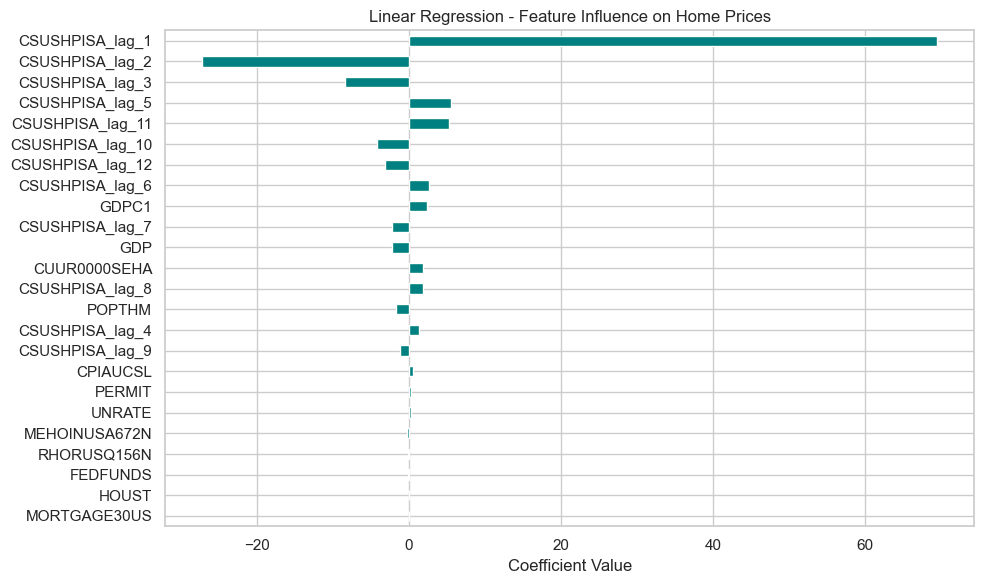

In [111]:
coefficients = pd.Series(lr.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
coefficients.plot(kind='barh', color='teal')
plt.title("Linear Regression - Feature Influence on Home Prices")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Linear Regression - Actual vs Prediction**

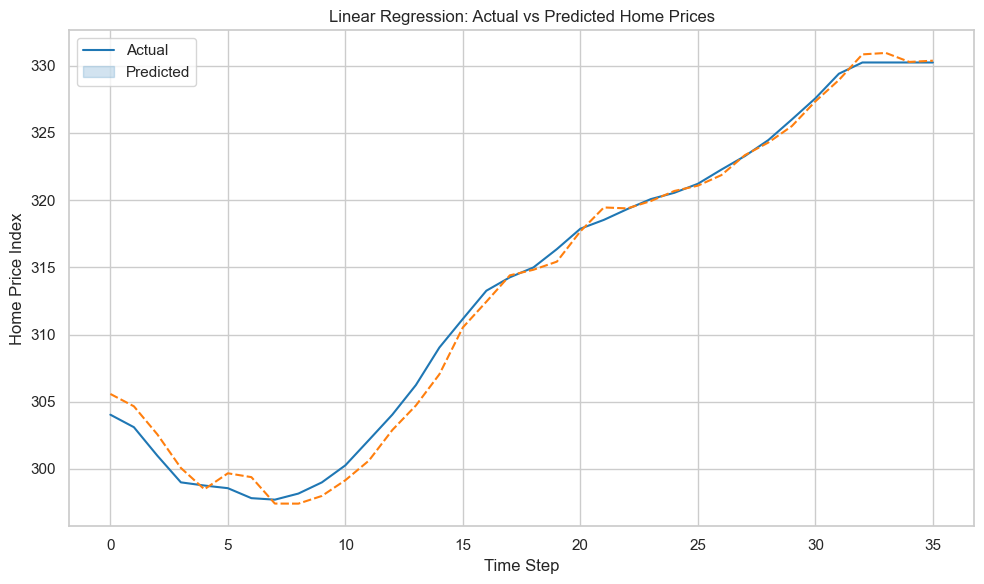

In [112]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
results_df = results_df.reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, palette='tab10')
plt.title('Linear Regression: Actual vs Predicted Home Prices')
plt.xlabel('Time Step')
plt.ylabel('Home Price Index')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()

# Show plot
plt.show()

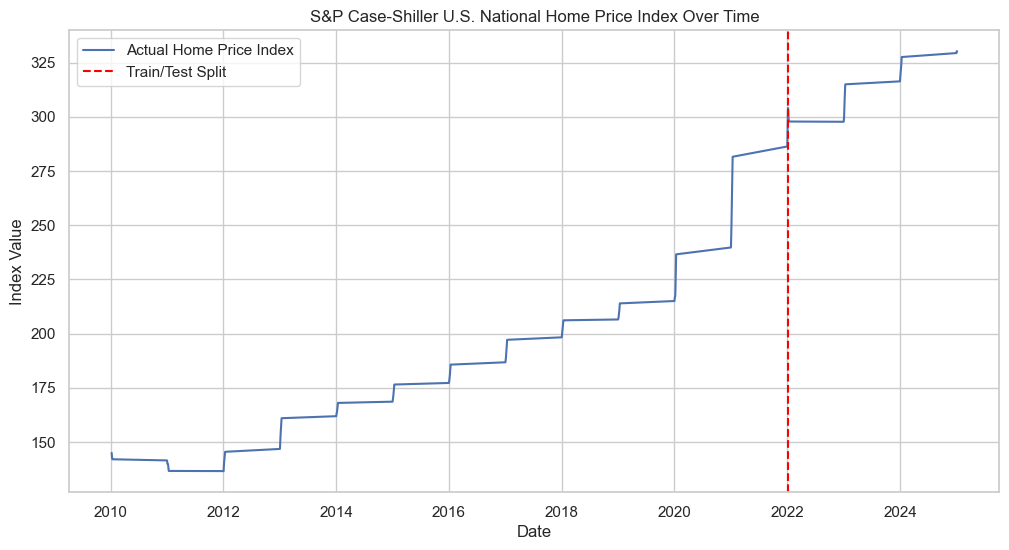

In [113]:
plt.figure(figsize=(12, 6))
plt.plot(clean_df['observation_date'], clean_df['CSUSHPISA'], label="Actual Home Price Index")
plt.axvline(x=clean_df['observation_date'].iloc[train_size], color='red', linestyle='--', label='Train/Test Split')
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.title("S&P Case-Shiller U.S. National Home Price Index Over Time")
plt.legend()
plt.grid(True)
plt.show()

# **Model – Random Forest Regression**

In [114]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate_model("Random Forest", y_test, y_pred_rf)


Random Forest Results:
R^2: -3.2908972686151197
MAE: 19.314022222221904
RMSE: 23.61449766923959


## **Feature Importance using Random Forest Regression**

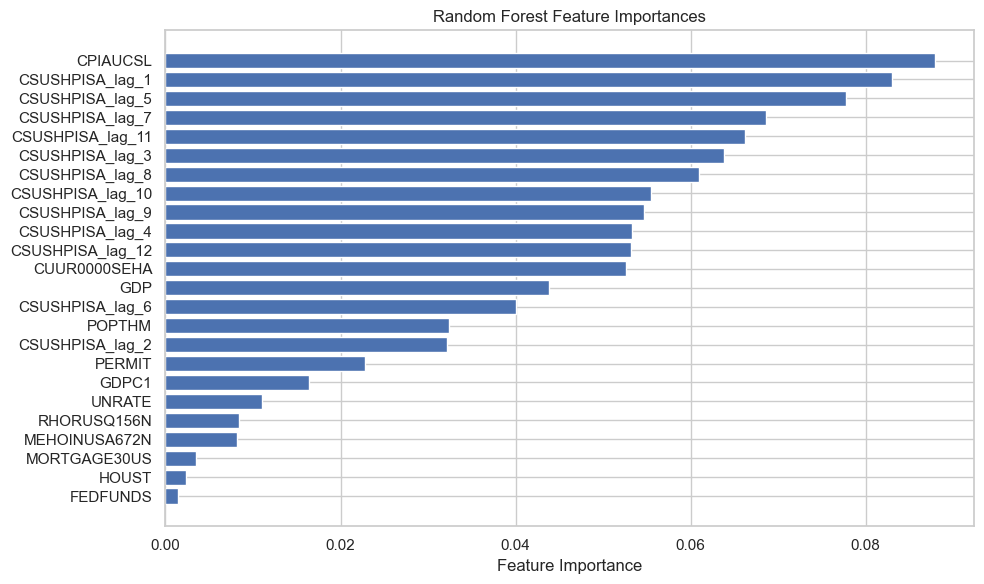

In [115]:
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(np.array(X_train.columns)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **Model - XGBoost**

In [116]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model("XGBoost", y_test, y_pred_xgb)


XGBoost Results:
R^2: -0.8396203082057152
MAE: 12.477134223090282
RMSE: 15.462109723234128


<Figure size 1000x800 with 0 Axes>

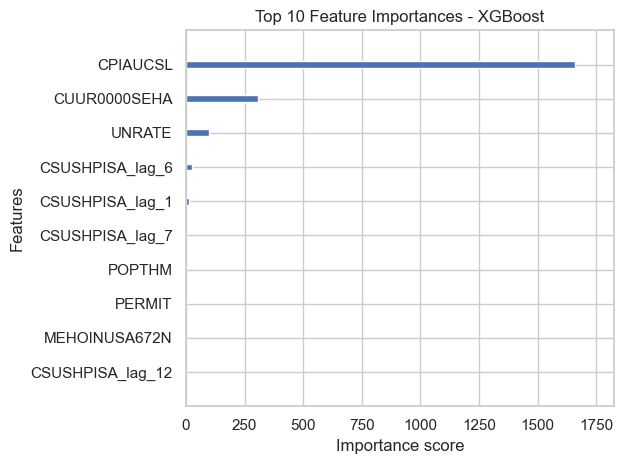

In [117]:
from xgboost import plot_importance

# Assuming your trained model is named xgb_model
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type='gain', show_values=False)
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()


## **Correlation Matrix**

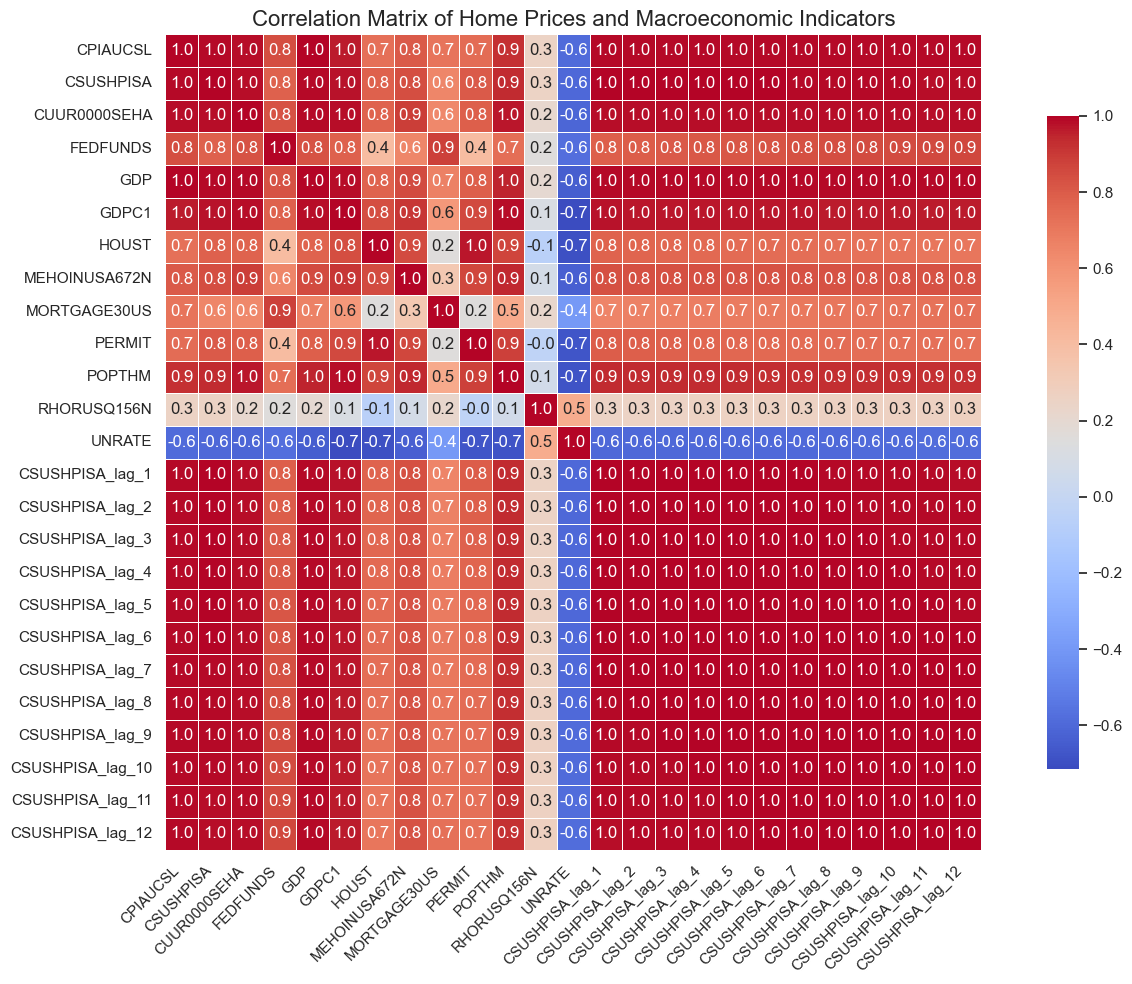

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(clean_df.corr(numeric_only=True), 
            annot=True, 
            cmap='coolwarm', 
            fmt='.1f', 
            linewidths=0.5, 
            square=True, 
            cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Home Prices and Macroeconomic Indicators", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



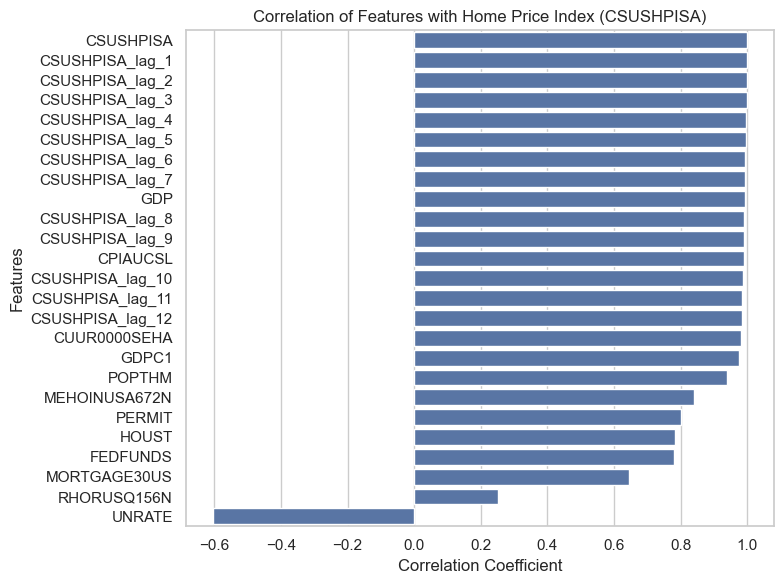

In [126]:
target_corr = clean_df.corr(numeric_only=True)['CSUSHPISA'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title("Correlation of Features with Home Price Index (CSUSHPISA)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


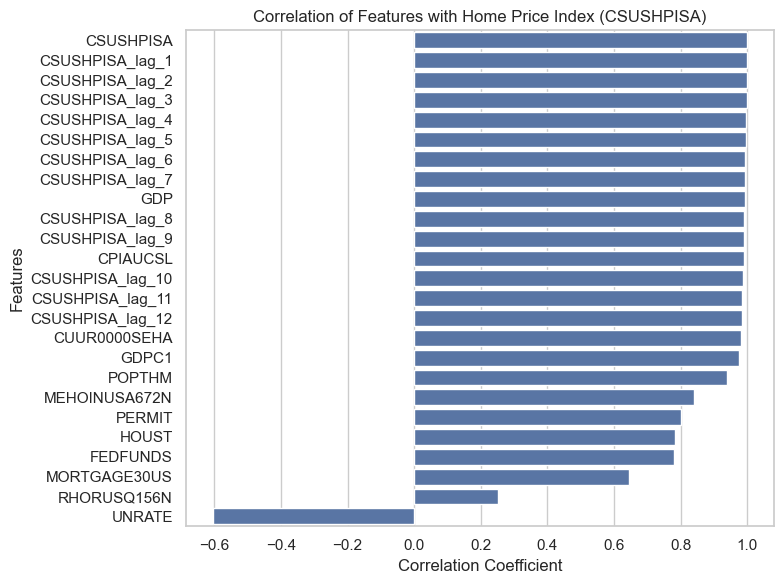

In [128]:
# Barplot of correlations with CSUSHPISA
plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title("Correlation of Features with Home Price Index (CSUSHPISA)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


## **Model Comparision**

In [121]:

model_results = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "ARIMA": arima_forecast,
    "XGBoost": y_pred_xgb
}

In [122]:
metrics = []
for name, pred in model_results.items():
    n = min(len(y_test), len(pred))
    y_true = y_test.values[:n]
    y_pred = pred[:n]
    metrics.append({
        "Model": name,
        "R²": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    })

In [123]:
metrics_df = pd.DataFrame(metrics).set_index("Model").round(4)
print(metrics_df)

                       R²      MAE     RMSE
Model                                      
Linear Regression  0.9937   0.7132   0.9065
Random Forest     -3.2909  19.3140  23.6145
ARIMA             -0.7859  14.5140  15.2349
XGBoost           -0.8396  12.4771  15.4621


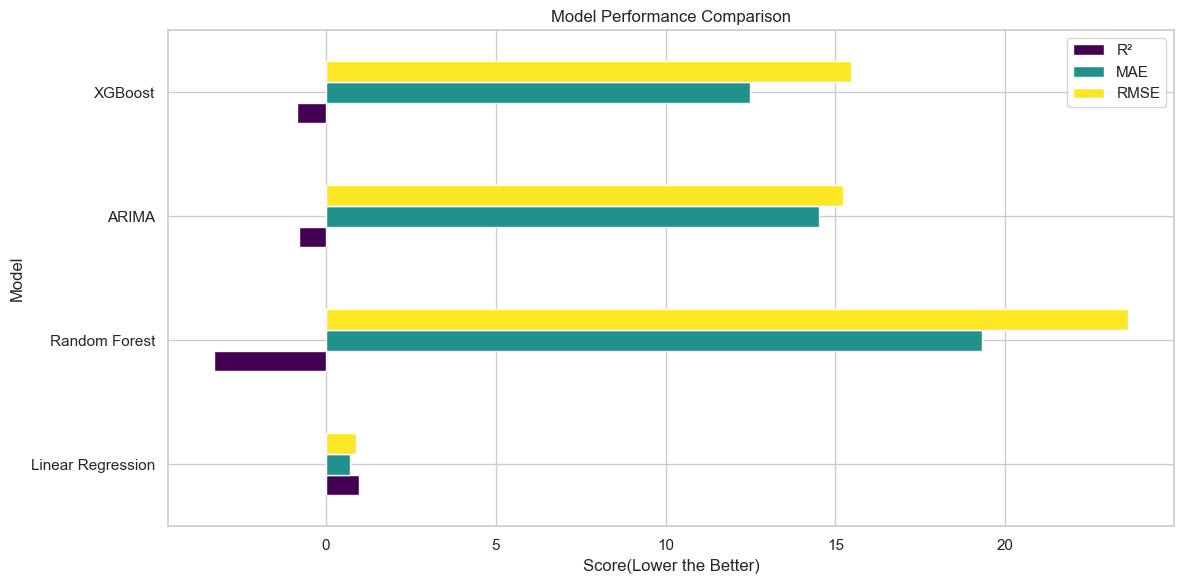

In [124]:
metrics_df.plot(kind='barh', figsize=(12, 6), colormap='viridis')
plt.title("Model Performance Comparison")
plt.xlabel("Score(Lower the Better)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
# Top 10 influential features
top_features = coefficients.head(50)
print("Top 10 Influential Features:\n", top_features)


Top 10 Influential Features:
 CSUSHPISA_lag_1     69.502320
CSUSHPISA_lag_2    -27.189658
CSUSHPISA_lag_3     -8.370644
CSUSHPISA_lag_5      5.552482
CSUSHPISA_lag_11     5.313856
CSUSHPISA_lag_10    -4.142296
CSUSHPISA_lag_12    -3.141243
CSUSHPISA_lag_6      2.687645
GDPC1                2.372177
CSUSHPISA_lag_7     -2.277789
GDP                 -2.268905
CUUR0000SEHA         1.858044
CSUSHPISA_lag_8      1.794279
POPTHM              -1.677431
CSUSHPISA_lag_4      1.267009
CSUSHPISA_lag_9     -1.186499
CPIAUCSL             0.584992
PERMIT               0.300710
UNRATE               0.270916
MEHOINUSA672N       -0.183696
RHORUSQ156N         -0.121677
FEDFUNDS            -0.118704
HOUST                0.025890
MORTGAGE30US        -0.023055
dtype: float64
